<a href="https://colab.research.google.com/github/Daianb/Atari-Proyecto-Final/blob/Procedimiento/ATARIproyectofinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install baselines
!pip install tensorflow
!pip install keras

## Introducción
Este script muestra una implementación de Deep Q-Learning en el
Entorno `BreakoutNoFrameskip-v4`.

### Deep Q-Learning 
A medida que un agente realiza acciones y se mueve a través de un entorno, aprende a mapear
el estado observado del entorno a una acción. Un agente elegirá una acción.
en un estado dado basado en un "valor Q", que es una recompensa ponderada basada en el
recompensa más alta esperada a largo plazo. Un Q-Learning Agent aprende a realizar su
tarea tal que la acción recomendada maximiza las posibles recompensas futuras.
Este método se considera un método "Fuera de la política",
lo que significa que sus valores Q se actualizan asumiendo que se eligió la mejor acción, incluso
si no se eligió la mejor acción.

### Fuga de Atari
En este entorno, un tablero se desplaza por la parte inferior de la pantalla devolviendo una bola que
destruirá bloques en la parte superior de la pantalla.
El objetivo del juego es eliminar todos los bloques y romper el
nivel. El agente debe aprender a controlar el tablero moviéndose hacia la izquierda y hacia la derecha, devolviendo el
bola y eliminando todos los bloqueos sin que la bola pase el tablero.

### Nota
El papel de Deepmind entrenó para "un total de 50 millones de fotogramas (es decir, alrededor de 38 días de
experiencia de juego en total). Sin embargo, este script dará buenos resultados alrededor de 10
millones de fotogramas que se procesan en menos de 24 horas en una máquina moderna.

### Referencias
- [Q-Learning](https://link.springer.com/content/pdf/10.1007/BF00992698.pdf)
- [Deep Q-Learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)

# Setup


In [ ]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Parámetros de configuración para toda la instalación
seed = 42
gamma = 0.99  
'''Factor de descuento por recompensas pasadas'''
epsilon = 1.0  
'''Parámetro codicioso de épsilon'''
epsilon_min = 0.1 
'''Minimo Parámetro codicioso de épsilon'''
epsilon_max = 1.0  
'''Maximo Parámetro codicioso de épsilon'''
epsilon_interval = (
    epsilon_max - epsilon_min
)
'''Tasa a la que reducir la posibilidad de que se tomen medidas aleatorias'''
batch_size = 32  
'''Tamaño del lote tomado del búfer de reproducción'''
max_steps_per_episode = 10000

#Use el entorno Baseline Atari debido a las funciones de ayuda de Deepmind
env = make_atari("BreakoutNoFrameskip-v4")
# Deformar los marcos, escala de grises, estacar cuatro marcos y escalar a una proporción más pequeña
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

## Implementar Deep Q-Network

Esta red aprende una aproximación de la tabla Q, que es un mapeo entre
los estados y acciones que tomará un agente. Por cada estado tendremos cuatro
acciones que se pueden tomar. El entorno proporciona el estado, y la acción
se elige seleccionando el mayor de los cuatro valores Q predichos en la capa de salida.

In [ ]:
num_actions = 4


def create_q_model():
    '''Red definida por el artículo de Deepmind'''
    inputs = layers.Input(shape=(84, 84, 4,))

    # Circunvoluciones en los marcos de la pantalla.
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


#El primer modelo hace las predicciones de los valores Q que se utilizan para
# realizar una acción.
model = create_q_model()
'''Cree un modelo objetivo para la predicción de recompensas futuras.
Los pesos de un modelo de destino se actualizan cada 10000 pasos, por lo tanto, cuando el
pérdida entre los valores Q se calcula el valor Q objetivo es estable.'''

model_target = create_q_model()

## Train

In [ ]:
# En el artículo de Deepmind, usan RMSProp, sin embargo, Adam Optimizer
# mejora el tiempo de entrenamiento
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Buffers de reproducción de experiencia
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

'''Número de fotogramas para realizar una acción aleatoria y observar la salida'''
epsilon_random_frames = 50000
'''Número de cuadros para exploración'''
epsilon_greedy_frames = 1000000.0
'''Duración máxima de reproducción'''

#Nota: el documento de Deepmind sugiere 1000000, sin embargo, esto causa problemas de memoria
max_memory_length = 100000

update_after_actions = 4
'''Entrena al modelo después de 4 acciones'''

update_target_network = 10000
'''Con qué frecuencia actualizar la red de destino'''

loss_function = keras.losses.Huber()
'''Uso de la pérdida Huber para la estabilidad'''

while True:  # Corre hasta resolver
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
       # env.render(); Agregar esta línea mostraría los intentos
         # del agente en una ventana emergente.
        frame_count += 1

        # Utilice epsilon-greedy para la exploración
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Toma una acción random
            action = np.random.choice(num_actions)
        else:
            # Predecir los valores Q de la acción
             # Del estado del entorno
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Toma la mejor acción
            action = tf.argmax(action_probs[0]).numpy()

        # Probabilidad de decaimiento de realizar una acción aleatoria
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Aplicar la acción muestreada en nuestro entorno.
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        #Guardar acciones y estados en el búfer de reproducción
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Actualice cada cuatro fotogramas y una vez que el tamaño del lote supere los 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Obtenga índices de muestras para búferes de reproducción
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            #Uso de la comprensión de listas para muestrear desde el búfer de reproducción
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Cree los valores Q actualizados para los estados futuros muestreados
             # Use el modelo objetivo para la estabilidad
            future_rewards = model_target.predict(state_next_sample)
            #Valor Q = recompensa + factor de descuento * recompensa futura esperada
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # Si el cuadro final establece el último valor en -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            #Cree una máscara para que solo calculemos la pérdida en los valores Q actualizados
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Entrene el modelo en los estados y valores Q actualizados
                q_values = model(state_sample)

                # Aplique las máscaras a los valores Q para obtener el valor Q de la acción realizada
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calcule la pérdida entre el valor Q nuevo y el valor Q antiguo
                loss = loss_function(updated_q_values, q_action)

            # retropropagación
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # actualizar la red de destino con nuevos pesos
            model_target.set_weights(model.get_weights())
            # Detalles de registro
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limitar el estado y el historial de recompensas
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Actualice la recompensa en ejecución para verificar la condición para resolver
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  #Condición para dar por resuelta la tarea
        print("Solved at episode {}!".format(episode_count))
        break

## Visualización

Antes de algun entrenamiento:

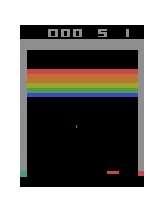

En las primeras etapas del entrenamiento:

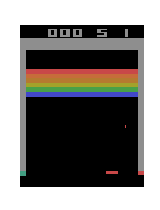

En etapas posteriores del entrenamiento:

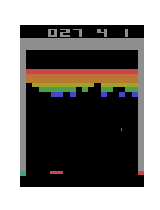